<a href="https://colab.research.google.com/github/DilsharaHerath/Intelligent-Fault-Detection-in-Rotating-Machinery/blob/main/CustomCNN_IEEE_SWC_Housing_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import Model
import torch

In [56]:
dataset_path = '/content/drive/MyDrive/IEEE_SWC/Dataset_HousingB'
class_names = os.listdir(dataset_path)
class_names

['BPFI_03',
 'Normal',
 'BPFI_10',
 'BPFI_30',
 'BPFO_03',
 'BPFO_10',
 'BPFO_30',
 'models']

In [57]:
files = os.listdir(dataset_path)
print(set(os.path.splitext(file)[1].lower() for file in files))

{''}


In [4]:
# from PIL import Image
# import os

# dataset_path = '/content/drive/MyDrive/IEEE_SWC/Dataset_HousingA'
# for root, dirs, files in os.walk(dataset_path):
#     for file in files:
#         if file.lower().endswith(('.jpg', '.jpeg')):
#             try:
#                 img_path = os.path.join(root, file)
#                 with Image.open(img_path) as img:
#                     img.verify()  # Check if image can be opened
#             except Exception as e:
#                 print(f"Error with file {img_path}: {e}")

In [5]:
# import os

# dataset_path = '/content/drive/MyDrive/IEEE_SWC/Dataset_HousingA'
# extensions = set()
# for root, dirs, files in os.walk(dataset_path):
#     for file in files:
#         ext = os.path.splitext(file)[1].lower()
#         extensions.add(ext)
# print("Found file extensions:", extensions)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)

# Load Data

tf.data.Dataset??


tf.data.Dataset.list_files

In [8]:
# tf.keras.utils.image_dataset_from_directory??
data = tf.keras.utils.image_dataset_from_directory(dataset_path, label_mode='categorical', image_size=(224,224))

Found 8607 files belonging to 7 classes.


# Preprocess Data



## Scale Data

In [9]:
data = data.map(lambda x, y: (x/255, y))

In [10]:
scaled_iterator = data.as_numpy_iterator()

In [11]:
batch = scaled_iterator.next()

In [12]:
batch[1]

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
 

In [13]:
batch[0].shape

(32, 224, 224, 3)

In [14]:
print(batch[0].max())
print(batch[0].min())

1.0
0.0


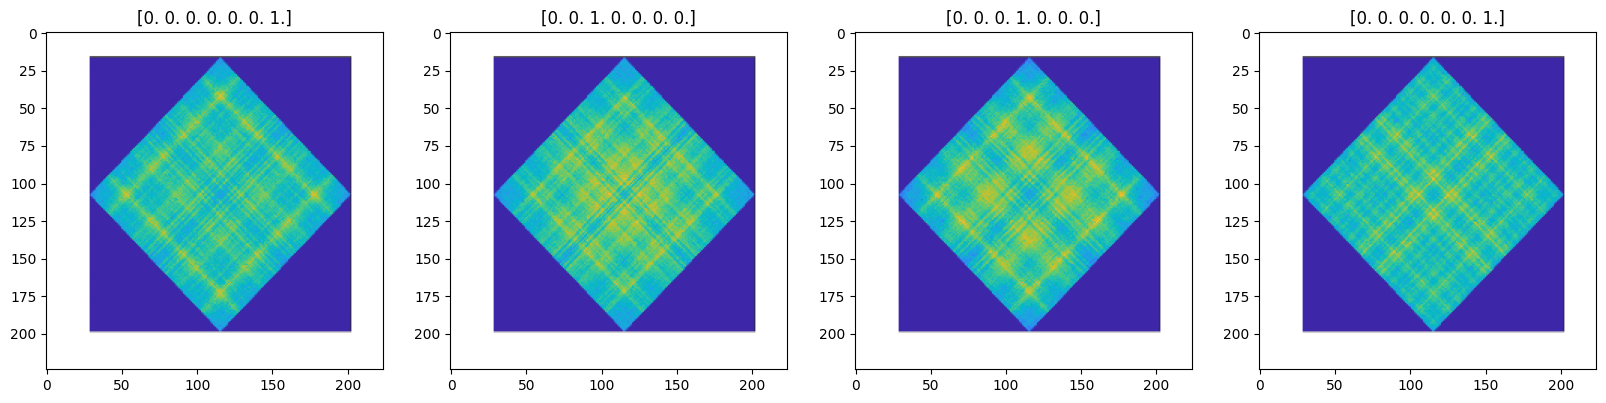

In [15]:
 fig, ax = plt.subplots(ncols=4, figsize=(20,20))
 for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

# Split Data

In [16]:
IMAGE_SIZE = [224, 224]

In [17]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

print('First Iteration :', train_size, val_size, test_size)

addition_data = train_size+val_size+test_size
if addition_data == len(data):
  pass
else:
  additional = len(data) - addition_data
  test_size += additional

print('Second Iteration :', train_size, val_size, test_size)
print('Total Length = ', len(data))
print('Sum of length = ', (train_size + val_size + test_size))

First Iteration : 188 53 26
Second Iteration : 188 53 28
Total Length =  269
Sum of length =  269


In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

print(len(train), len(val), len(test))

188 53 28


# Building the Model

## Build Deep Learning Model

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
# from keras.applications.vgg16 import VGG16

# vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# # Don't train existing weights
# vgg.trainable = False

In [48]:
# # Adding custom layers
# x = Flatten()(vgg.output)
# x = Dense(1024, activation='relu')(x)
# prediction = Dense(7, activation='softmax')(x)

# # Create a model object
# model = Model(inputs=vgg.input, outputs=prediction)

# # Model compilation for binary classification
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
# model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,412,999 (154.16 MB)

 Trainable params: 25,698,311 (98.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import Input
from keras import layers

IMAGE_SIZE = [224, 224]

# Load the pre-trained VGG16 model without the top, and freeze its weights
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg.trainable = False  # Initially freeze all layers

# Optionally add data augmentation in the model pipeline (only during training)
data_augmentation = layers.RandomFlip("horizontal")

# Build the improved model
inputs = Input(shape=IMAGE_SIZE + [3])
x = data_augmentation(inputs)  # Augment data
x = vgg(x, training=False)      # Pass through VGG16
x = GlobalAveragePooling2D()(x) # Global pooling instead of flattening
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# Final prediction layer for 7 classes
prediction = Dense(7, activation='softmax')(x)

model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,113,543 (57.65 MB)

 Trainable params: 397,319 (1.52 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

In [23]:
# model = Sequential()
# model.add(Conv2D(16, (3,3), strides=1, padding='same', activation='relu', input_shape=(224,224,3)))
# model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))  # Optional
# model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,143 (24.59 MB)

 Trainable params: 6,447,143 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [26]:
logdir='/content/drive/MyDrive/IEEE_SWC/logs_VGG166'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1511s 8s/step - accuracy: 0.3891 - loss: 1.8281 - val_accuracy: 0.9275 - val_loss: 0.3427
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8489 - loss: 0.3986 - val_accuracy: 0.9711 - val_loss: 0.1103
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 134s 714ms/step - accuracy: 0.9038 - loss: 0.2654 - val_accuracy: 0.9652 - val_loss: 0.0839
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 121s 645ms/step - accuracy: 0.9262 - loss: 0.2006 - val_accuracy: 0.9699 - val_loss: 0.0678
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 138s 625ms/step - accuracy: 0.9319 - loss: 0.1692 - val_accuracy: 0.9688 - val_loss: 0.0717
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 711ms/step - accuracy: 0.9370 - loss: 0.1584 - val_accuracy: 0.9693 - val_loss: 0.0722
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 117s 623ms/step - accuracy: 0.9364 - loss: 0.1602 - val_accuracy: 0.9699 - val_loss: 0.0707
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 133s 710ms/step - accuracy: 0.9340 - loss

In [29]:
hist.history

{'accuracy': [0.5393949747085571,
  0.8730053305625916,
  0.9122340679168701,
  0.9338430762290955,
  0.9320146441459656,
  0.940990686416626,
  0.9363364577293396,
  0.9406582713127136,
  0.944481372833252,
  0.9454787373542786,
  0.9451462626457214,
  0.9507978558540344,
  0.9502992033958435,
  0.9524601101875305,
  0.9537898898124695],
 'loss': [1.2885764837265015,
  0.3353802561759949,
  0.23316890001296997,
  0.18057678639888763,
  0.16925522685050964,
  0.15150107443332672,
  0.15835241973400116,
  0.14594097435474396,
  0.13583125174045563,
  0.13172100484371185,
  0.1307423859834671,
  0.12085019052028656,
  0.12274663150310516,
  0.11909785866737366,
  0.10967611521482468],
 'val_accuracy': [0.9274764060974121,
  0.9711084961891174,
  0.9652122855186462,
  0.9699292182922363,
  0.96875,
  0.9693396091461182,
  0.9699292182922363,
  0.9693396091461182,
  0.9675707817077637,
  0.9728773832321167,
  0.9658018946647644,
  0.9705188870429993,
  0.9711084961891174,
  0.9693396091461

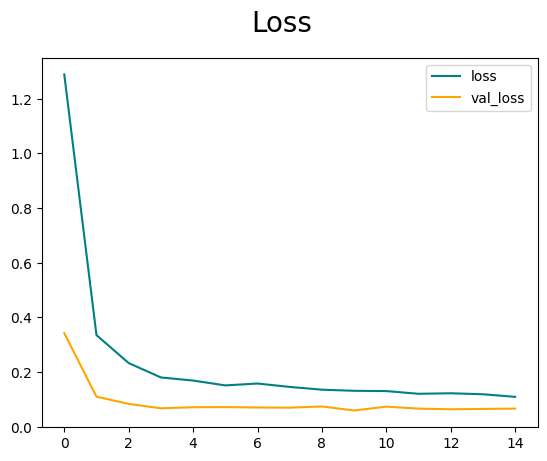

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

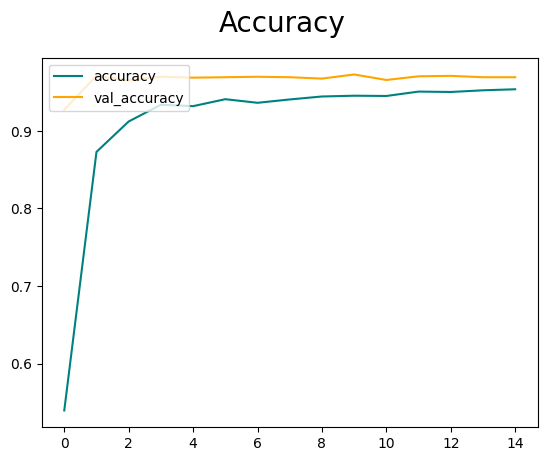

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# Evaluate Performance

In [32]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [33]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

In [35]:
print('Precision: ', precision.result().numpy())
print('Recall: ', recall.result().numpy())
print('Accuracy: ', accuracy.result().numpy())

Precision:  1.0
Recall:  0.95083797
Accuracy:  0.9564246


In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming:
# - val_data is your validation dataset (batched)
# - model is your trained Keras model

y_true = []
y_pred = []

for images, labels in val:
    # Get true labels (convert one-hot to integers if needed)
    if labels.shape[-1] == 7:  # If labels are one-hot encoded
        labels = np.argmax(labels, axis=1)
    y_true.extend(labels)

    # Predict and get class indices
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [37]:
cm = confusion_matrix(y_true, y_pred, normalize='true')
print(cm)

[[0.94240838 0.         0.         0.         0.0104712  0.04712042
  0.        ]
 [0.00478469 0.95215311 0.         0.00478469 0.         0.03827751
  0.        ]
 [0.00564972 0.         0.94915254 0.         0.         0.04519774
  0.        ]
 [0.         0.         0.         0.96517413 0.01492537 0.0199005
  0.        ]
 [0.00515464 0.         0.         0.         0.96391753 0.03092784
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         0.00190476 0.01142857
  0.98666667]]


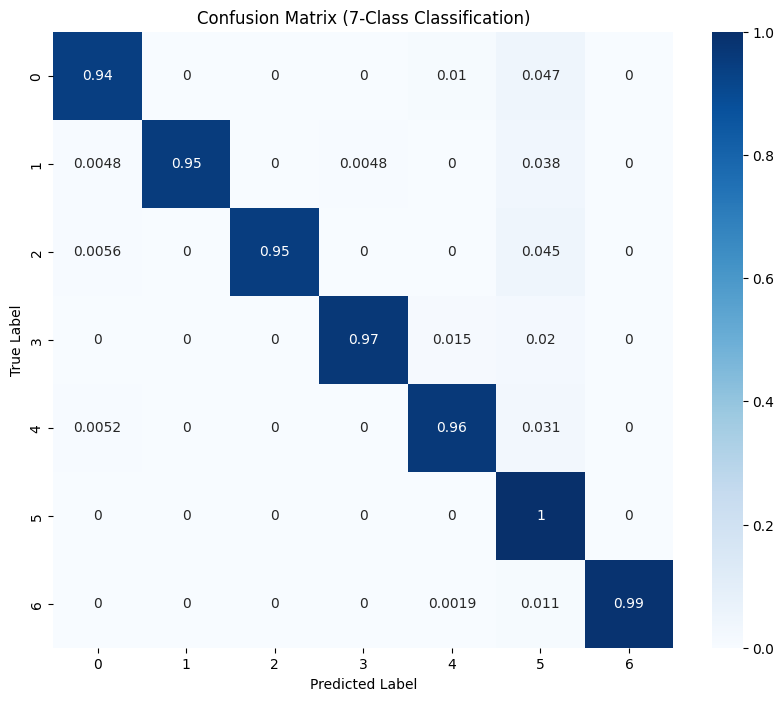

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=range(7),
            yticklabels=range(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (7-Class Classification)')
plt.show()

In [39]:
from sklearn.metrics import classification_report
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4  # Decimal precision
)
print(report)

              precision    recall  f1-score   support

     BPFI_03     0.9836    0.9424    0.9626       191
      Normal     1.0000    0.9522    0.9755       209
     BPFI_10     1.0000    0.9492    0.9739       177
     BPFI_30     0.9949    0.9652    0.9798       201
     BPFO_03     0.9689    0.9639    0.9664       194
     BPFO_10     0.8292    1.0000    0.9066       199
     BPFO_30     1.0000    0.9867    0.9933       525

    accuracy                         0.9699      1696
   macro avg     0.9681    0.9656    0.9654      1696
weighted avg     0.9739    0.9699    0.9708      1696



In [40]:
model.save(os.path.join(dataset_path, 'VGG16_HousingB.h5'))

## Test

TypeError: Image data of dtype object cannot be converted to float

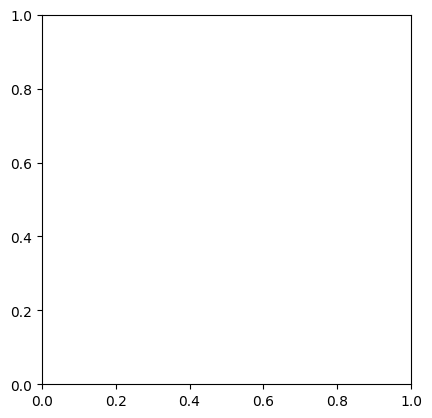

In [41]:
test_image_path = '/content/drive/MyDrive/IEEE_SWC/test'
img = cv2.imread(test_image_path)
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.iamge.resize(img, (256,256))
plt.imshow(resize.numpy().as_type(int))
plt.show

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

In [ ]:
from tensorflow.keras.models import load_model